In [ ]:
# Installations and imports
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Upload dataset
uploaded = files.upload()
filename = list(uploaded.keys())[0]
train_df = pd.read_csv(filename)

Saving train_cleaned.csv to train_cleaned.csv


In [ ]:
toxic_categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

X = train_df['comment_text'].fillna('').values
y = train_df[toxic_categories].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y.any(axis=1)
)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Training samples: 127651, Test samples: 31913


In [ ]:
# class weights for imbalance
class_weights = {}
for i, category in enumerate(toxic_categories):
    weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train[:, i]),
        y=y_train[:, i]
    )
    class_weights[i] = weights[1]

In [ ]:
# Text preprocessing
MAX_FEATURES = 20000
MAX_LENGTH = 200

tokenizer = Tokenizer(num_words=MAX_FEATURES, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')

In [ ]:
# CNN Model
def create_cnn_model():
    input_layer = tf.keras.layers.Input(shape=(MAX_LENGTH,))
    embedding = Embedding(MAX_FEATURES, 100)(input_layer)

    # Multiple parallel convolutional layers with different kernel sizes
    conv_blocks = []
    for kernel_size in [3, 4, 5]:  # Captures tri-gram, 4-gram, and 5-gram patterns
        conv = Conv1D(128, kernel_size, activation='relu', padding='same')(embedding)
        pool = GlobalMaxPooling1D()(conv)
        conv_blocks.append(pool)

    # Concatenate all conv outputs
    concatenated = tf.keras.layers.concatenate(conv_blocks)

    dropout1 = Dropout(0.5)(concatenated)
    dense1 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.3)(dense1)
    output = Dense(len(toxic_categories), activation='sigmoid')(dropout2)

    model = tf.keras.Model(inputs=input_layer, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

cnn_model = create_cnn_model()

In [ ]:
# Train model
history = cnn_model.fit(
    X_train_pad, y_train,
    batch_size=64,
    epochs=5,
    validation_split=0.1,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/5
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 512s 284ms/step - accuracy: 0.6666 - loss: 0.6704 - val_accuracy: 0.9938 - val_loss: 0.0531
Epoch 2/5
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 560s 283ms/step - accuracy: 0.8774 - loss: 0.3061 - val_accuracy: 0.9938 - val_loss: 0.0522
Epoch 3/5
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 513s 286ms/step - accuracy: 0.9247 - loss: 0.2664 - val_accuracy: 0.9921 - val_loss: 0.0516
Epoch 4/5
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 512s 285ms/step - accuracy: 0.8179 - loss: 0.2335 - val_accuracy: 0.9829 - val_loss: 0.0528
Epoch 5/5
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 512s 285ms/step - accuracy: 0.8477 - loss: 0.1965 - val_accuracy: 0.9308 - val_loss: 0.0556


In [ ]:
# probability predictions
y_pred_proba = cnn_model.predict(X_test_pad)

# per-class thresholds
thresholds = {
    'toxic': 0.5,
    'severe_toxic': 0.3,
    'obscene': 0.5,
    'threat': 0.2,
    'insult': 0.5,
    'identity_hate': 0.25
}

y_pred_optimized = np.zeros_like(y_pred_proba)
for i, category in enumerate(toxic_categories):
    y_pred_optimized[:, i] = (y_pred_proba[:, i] > thresholds[category]).astype(int)

998/998 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step


In [ ]:
def evaluate_model(y_true, y_pred, y_pred_proba, categories):
    results = {}

    results['accuracy'] = accuracy_score(y_true, y_pred)
    results['precision'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    results['recall'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    results['f1'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    results['roc_auc'] = roc_auc_score(y_true, y_pred_proba, average='macro')

    class_metrics = {}
    for i, category in enumerate(categories):
        class_metrics[category] = {
            'precision': precision_score(y_true[:, i], y_pred[:, i], zero_division=0),
            'recall': recall_score(y_true[:, i], y_pred[:, i], zero_division=0),
            'f1': f1_score(y_true[:, i], y_pred[:, i], zero_division=0),
            'roc_auc': roc_auc_score(y_true[:, i], y_pred_proba[:, i]),
            'support': np.sum(y_true[:, i])
        }

    return results, class_metrics

# Evaluate with optimized thresholds
results, class_metrics = evaluate_model(y_test, y_pred_optimized, y_pred_proba, toxic_categories)

print(f"Accuracy:  {results['accuracy']:.4f}")
print(f"Precision: {results['precision']:.4f}")
print(f"Recall:    {results['recall']:.4f}")
print(f"F1-Score:  {results['f1']:.4f}")
print(f"ROC-AUC:   {results['roc_auc']:.4f}")

for i, category in enumerate(toxic_categories):
    metrics = class_metrics[category]
    print(f"{category:15} - Prec: {metrics['precision']:.4f}, Rec: {metrics['recall']:.4f}, "
          f"F1: {metrics['f1']:.4f}, Support: {metrics['support']}")

Accuracy:  0.9033
Precision: 0.5424
Recall:    0.6588
F1-Score:  0.5842
ROC-AUC:   0.9730
toxic           - Prec: 0.7453, Rec: 0.7725, F1: 0.7587, Support: 3046
severe_toxic    - Prec: 0.3392, Rec: 0.6951, F1: 0.4559, Support: 305
obscene         - Prec: 0.7783, Rec: 0.8363, F1: 0.8063, Support: 1662
threat          - Prec: 0.3564, Rec: 0.3673, F1: 0.3618, Support: 98
insult          - Prec: 0.7227, Rec: 0.7176, F1: 0.7202, Support: 1576
identity_hate   - Prec: 0.3126, Rec: 0.5637, F1: 0.4022, Support: 259


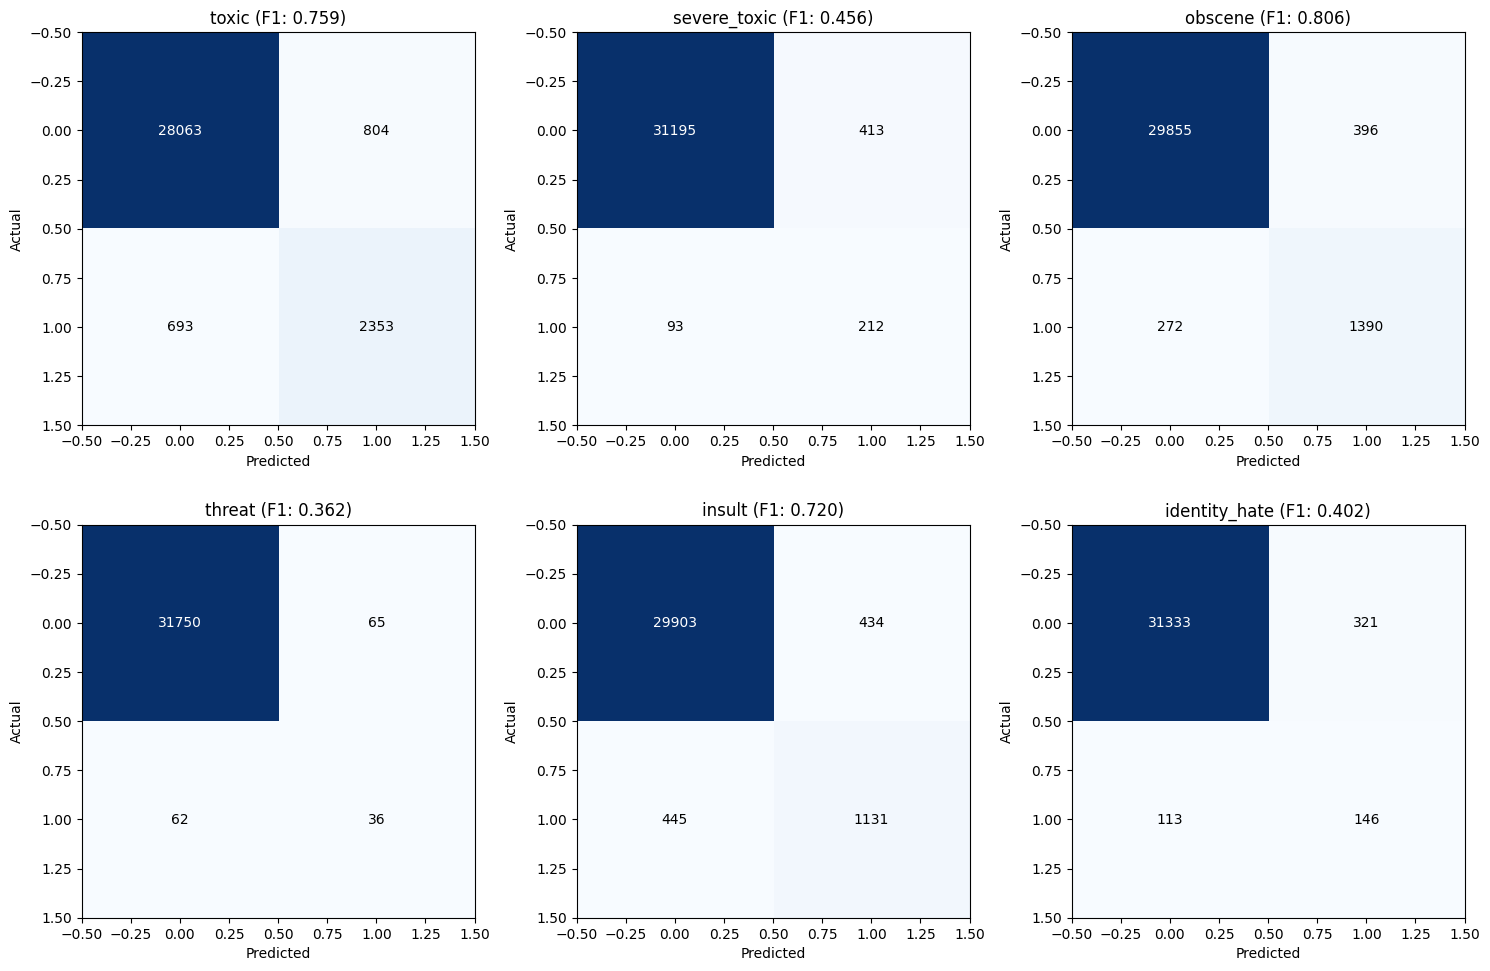

In [ ]:
# Confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, category in enumerate(toxic_categories):
    cm = confusion_matrix(y_test[:, i], y_pred_optimized[:, i])
    axes[i].imshow(cm, cmap='Blues')
    axes[i].set_title(f'{category} (F1: {class_metrics[category]["f1"]:.3f})')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

    for i_i, i_j in np.ndindex(cm.shape):
        axes[i].text(i_j, i_i, f'{cm[i_i, i_j]}', ha='center', va='center',
                    color='white' if cm[i_i, i_j] > cm.max()/2 else 'black')

plt.tight_layout()
plt.show()